create a custom image transofrm composition
flip vert, flip hor, blur, rotate.

https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

when creating a custom transform use transforms.functional to use transforms as functions

In [17]:
# Install libraries

%pip install torch torchvision matplotlib pillow numpy

import os
import torch
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
from typing import Tuple, Dict
from collections import defaultdict


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Setting up train, test folders paths

train_dataset_originals  = "./Intel_Image_Classification/train_segment/originals"
# train_dataset = "./Intel_Image_Classification/train_segment/augmented"
test_dataset  = "./Intel_Image_Classification/test_segment"

In [3]:
# Figguring out (height, width, imager/class, format) of images from either training or testing sets

def get_info_from_data_set(path: str) -> Tuple[int, int, Dict[str, int], Dict[str, int]]:
    heights = []
    widths  = []
    formats = defaultdict()
    images_per_class = dict()

    for image_class in os.listdir(path):
        image_class_dir = os.path.join(path, image_class)
        class_images    = os.listdir(image_class_dir)

        images_per_class[image_class] = len(class_images)

        for image in class_images:
            image_path     = os.path.join(image_class_dir, image)
            image_as_array = np.array(Image.open(image_path))
            
            h, w, c = image_as_array.shape

            heights.append(h)
            widths.append(w) 

            image_name, image_extension = os.path.splitext(image_path)

            if image_extension not in formats.keys():
                formats[image_extension] = 0
            else:
                formats[image_extension] += 1
            

    average_height = sum(heights) / len(heights)
    average_wifth  = sum(widths) / len(widths)

    return (round(average_height), round(average_wifth), images_per_class, formats)

get_info_from_data_set(train_dataset_originals)

(150,
 150,
 {'buildings': 2191,
  'forest': 2271,
  'glacier': 2404,
  'mountain': 2512,
  'sea': 2274,
  'street': 2382},
 defaultdict(None, {'.jpg': 14033}))

In [4]:
(average_img_h, average_img_w, images_per_class, formats) = get_info_from_data_set(train_dataset_originals)
print(f'average_height:   {average_img_h}')
print(f'average_width:    {average_img_w}')
print(f'formats:          {formats}')
print(f'images_per_class: {images_per_class}')

average_height:   150
average_width:    150
formats:          defaultdict(None, {'.jpg': 14033})
images_per_class: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


In [7]:
# Creating training, testing datasets from the local dir
# Creating an iterator over random batches (DataLoader) 

transform = v2.Compose([
    v2.ToImage(),       
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),              
    v2.Resize(size=(round(average_img_h), round(average_img_w)))  
])

train_set = torchvision.datasets.ImageFolder(root=train_dataset_originals, transform=transform)
test_set  = torchvision.datasets.ImageFolder(root=test_dataset)

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=64,  shuffle=True)

print(f'batches_in_train_dataloader: {len(train_dataloader)}')
print(f'batches_in_test_dataloader:  {len(test_dataloader)}')

batches_in_train_dataloader: 220
batches_in_test_dataloader:  47


In [8]:
# Getting alpabetical labels from the dataset

labels_numbers_to_strings = {val: key for key, val in train_dataloader.dataset.class_to_idx.items()}
labels_strings_to_numbers = train_dataloader.dataset.class_to_idx

print(f'batches: {len(train_dataloader)}')
print(f'labels_numbers_to_strings: {labels_numbers_to_strings}')
print(f'labels_strings_to_numbers: {labels_strings_to_numbers}')

batches: 220
labels_numbers_to_strings: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
labels_strings_to_numbers: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


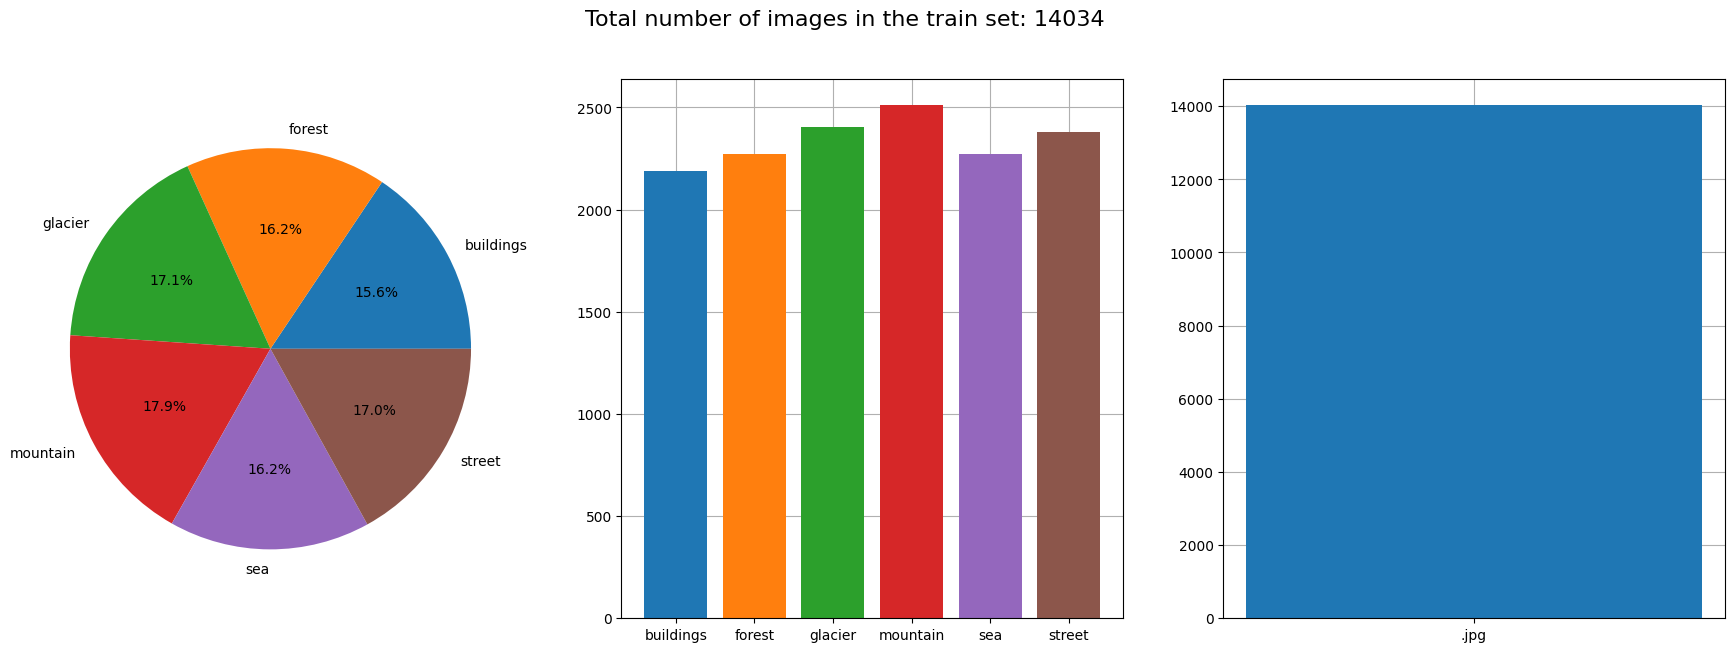

In [9]:
# Creating plots
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

# Creating pie
wedges, texts, autotext = ax[0].pie(
    x      = list(images_per_class.values()), 
    labels = list(images_per_class.keys()) ,  
    autopct= lambda pct: f'{pct:.1f}%'
    ) 

# Remembering pie colors to use on the next plot
pie_colors = [wedge.get_facecolor() for wedge in wedges]

# Creating a bar plot for image/class distr
ax[1].bar(
    images_per_class.keys(), 
    images_per_class.values(), 
    color  = pie_colors,
    zorder = 2
    )   
ax[1].grid()

# Creating a bar plot for img type distr
ax[2].bar(
    formats.keys(), 
    formats.values(), 
    zorder = 2
    ) 
ax[2].grid()

fig.suptitle(f'Total number of images in the train set: {sum(images_per_class.values())}', fontsize=16)

plt.show()

In [ ]:
# # Creating a folder with original images and aungment variants to expandd the dataset

# transform_augmented = v2.Compose([
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     # v2.RandomCrop(size=(round(average_img_h / 2), round(average_img_w / 2))),
#     # v2.RandomCrop(size=(round(average_img_h / 2), round(average_img_w / 2))),
#     v2.RandomHorizontalFlip(p=1.0),
#     # v2.RandomVerticalFlip(p=1.0),
#     # v2.GaussianBlur(kernel_size=(7, 13), sigma=(9, 11))
#     v2.Resize(size=(round(average_img_h), round(average_img_w))),
# ])

# train_dataset_augmented = torchvision.datasets.ImageFolder(root=train_dataset_originals, transform=transform_augmented) 

# train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

# print(f'batches_in_train_dataloader_augmented: {len(train_dataloader_augmented)}')

batches_in_train_dataloader_augmented: 220


In [10]:
# Used for displaying multiple images on a pyplot plot
def print_images(images_as_vectors, labels_strings=None, labels_numeric=None):
    if labels_strings != None and labels_numeric != None:
        raise ValueError('Optional labels_strings, labels_numeric cannot both be set, use 1 of them')   
    
    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_strings supposed to have the same size")

    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_numeric supposed to have the same size")
    
    # Create a single plot for multiple images (one subplot per image)
    # The number of columns in the plot is determined by the number of images to display
    fig, axes = plt.subplots(ncols=len(images_as_vectors), figsize=(20, 20))

    labels = [''] * len(images_as_vectors)
    if labels_strings != None:
        labels = labels_strings
    elif labels_numeric != None:
        labels = [labels_numbers_to_strings[int(i)] for i in labels_numeric]

    for index, image_as_vector in enumerate(images_as_vectors):
        image_as_vector = np.transpose(image_as_vector, (1, 2, 0))

        axes[index].imshow(image_as_vector)
        axes[index].title.set_text(labels[index])
        axes[index].title.set_fontsize(25)

        # Removing the x and y ticks for a cleaner display
        axes[index].set_xticks([])
        axes[index].set_yticks([])
    
    plt.show()

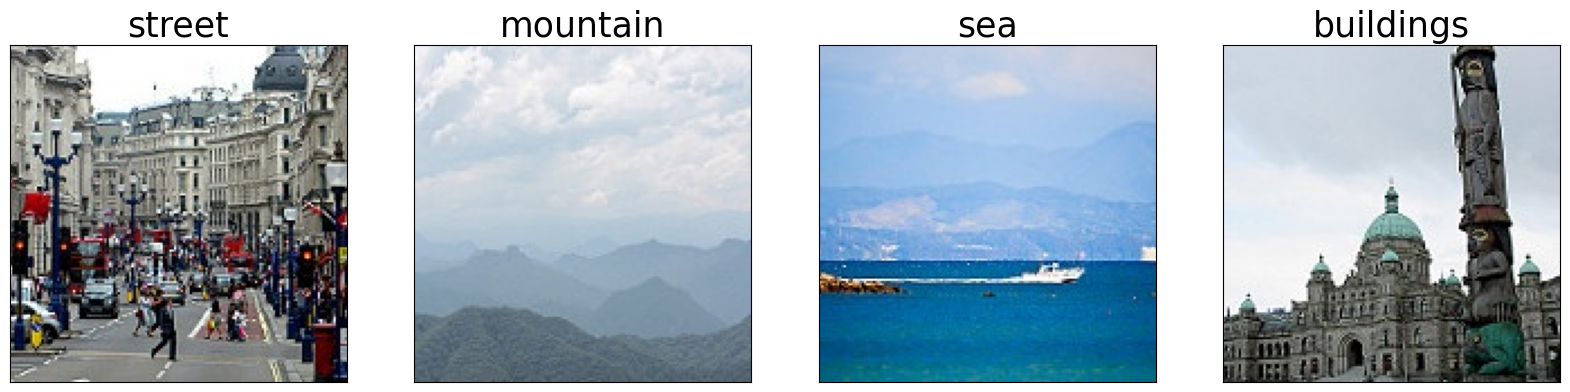

In [11]:
# Displaying some of the augmented images

first_batch = next(iter(train_dataloader))
first_batch_images         = first_batch[0]
first_batch_labels_numeric = first_batch[1]

print_images(first_batch_images[:4], labels_numeric=first_batch_labels_numeric)